### math 510 project

In [189]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [190]:
def median_twenty(t):
    n = len(t)
    if n <= 20:
        return t
    res = t[:20]
    for i in range(20, n):
        s = sorted(t[i - 20 : i])
        res.append(s[10])
    return res

In [196]:
# calculate dx/dt (equation 3, p. 18)
def calculate_response(x):
    return np.tanh(x)

def calculate_derivative(x, u, J, B, tau):
    r = calculate_response(x)
    return (1.0 / tau) * (-x + np.dot(J,r) + np.dot(B,u))

In [197]:
# calculate euler approximation of the time step
# def euler_timestep(x, u, J, B, tau, delta_t):
#     return x + calculate_derivative(x, u, J, B, tau) * delta_t

# hacky version to squeeze out some performance!
def euler_timestep(x, u, J, B, tau, delta_t):
    return x * 0.96666666 + (np.dot(J,np.tanh(x)) + np.dot(B,u)) * 0.0333333

In [198]:
def apply_perturbations(x, p, N):
    positions = np.random.rand(N,1) < p
    perturbations = np.random.rand(N,1) - 0.5
    perturbations[0][0] = 0.0  # don't perturb the output neuron
    return x + positions * perturbations

In [199]:
# note: the choice of bias neurons is arbitrary
def enforce_biases(x):
    x[10][0] = 1.0
    x[11][0] = 1.0
    x[12][0] = 1.0
    x[13][0] = -1.0

In [202]:
def update_learning_potential(E, r_prev, x, x_average, N):
    res = np.outer(x - x_average, r_prev)
    return E + res * res * res

In [203]:
def run_trial_task_1(J, B, tau, delta_t, N, M, expected_reward, eta, plot_output = False):
    E = np.zeros((N,N))  # learning potential
    x_alpha = 0.95       # decay of short-term running average of x
    r_alpha = 0.75       # decay of expected reward
    p = 0.003            # probability of perturbation
    
    # set up the external inputs
    external = {'A': np.array([1.,0.]).reshape(2,1), 'B': np.array([0.,1.]).reshape(2,1)}
    choice1 = random.choice(['A', 'B'])
    choice2 = random.choice(['A', 'B'])
    trial_type = choice1 == choice2
    reward_trial_type = choice1 + choice2
    target_response = -1.0 if trial_type else 1.0
    if plot_output: print "Stimulus 1:", choice1
    if plot_output: print "Stimulus 2:", choice2
    u1 = external[choice1]
    u2 = external[choice2]
    u_s = [u1] * 200 + [np.zeros((M,1))] * 200 + [u2] * 200 + [np.zeros((M,1))] * 400
    
    # initialize the excitation
    x = 0.1 * (2 * np.random.rand(N,1) - 1)
    x_average = np.zeros((N,1))
    r_s = []
    
    # run the trial timesteps
    for timestep in range(1000):
        u = u_s[timestep]
        r_prev = np.tanh(x)
        r_s.append(r_prev[0][0])
        x_average = x_alpha * x + (1 - x_alpha) * x_average
        x = apply_perturbations(x, p, N)
        enforce_biases(x)
        x = euler_timestep(x, u, J, B, tau, delta_t)
        E = update_learning_potential(E, r_prev, x, x_average, N)
        
    
    # compute the error
    trial_error = sum(map(lambda x: np.abs(target_response - x), r_s[800:])) / 200.0
    prev_expected_reward = expected_reward[reward_trial_type]
    trial_reward = trial_error - prev_expected_reward
    expected_reward[reward_trial_type] = r_alpha * prev_expected_reward + (1 - r_alpha) * trial_error
    
    # return (weight_change, expected_reward, trial_error, r_s) tuple
    return (eta * trial_reward * prev_expected_reward * E, expected_reward, trial_error, r_s)

In [204]:
def task1(num_trials):
    
    N = 200         # number of neurons (200)
    M = 2           # number of external inputs to the network (2)
    T = 1           # total time of the simulation (?)
    delta_t = 0.001 # length of the time step (1 ms)
    tau = 0.03      # relaxation time constant (30 ms)
    g = 1.5         # scaling factor (1.5)
    eta = 0.1       # learning rate (0.5 paper, 0.1 code)
    
    J = np.random.normal(loc=0.0, scale=(g/np.sqrt(N)), size=(N,N))
    B = 2 * np.random.rand(N,M) - 1
    
    expected_reward = {'AA': 0.0, 'AB': 0.0, 'BA': 0.0, 'BB': 0.0}
    
    e_s = []
    t_s = []
    
    # plot the output before training
    print "BEFORE TRAINING"
    print "==============="
    _, _, _, r_s = run_trial_task_1(J, B, tau, delta_t, N, M, expected_reward, eta, plot_output = True)
    plt.plot(list(range(1000)), r_s)
    plt.title('r(x[0]) over time')
    plt.xlabel('timestep (ms)')
    plt.ylabel('response')
    plt.show()

    # print the weights
    #print
    #print J
    #print
    
    for trial in range(num_trials):
        weight_change, expected_reward, trial_error, _ = run_trial_task_1(J, B, tau, delta_t, N, M, expected_reward, eta)
        J -= np.clip(weight_change, -0.0003, 0.0003)
        e_s.append(trial_error)
        t_s.append(trial)
    
    # plot the output before training
    print "AFTER TRAINING"
    print "=============="
    _, _, _, r_s = run_trial_task_1(J, B, tau, delta_t, N, M, expected_reward, eta, plot_output = True)
    plt.plot(list(range(1000)), r_s)
    plt.title('r(x[0]) over time')
    plt.xlabel('timestep (ms)')
    plt.ylabel('response')
    plt.show()
    
    # print the weights
    #print
    #print J
    #print
    
    # plot error
    plt.plot(t_s, median_twenty(e_s))
    plt.title('median trial error over time')
    plt.xlabel('trial')
    plt.ylabel('error')
    plt.show()
    
    return

BEFORE TRAINING
Stimulus 1: A
Stimulus 2: B


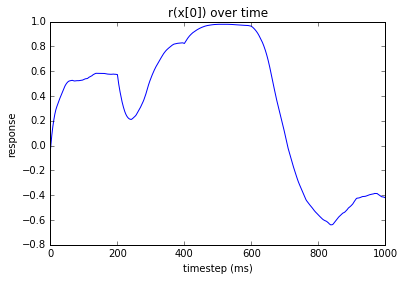


[[-0.0835611  -0.12487377  0.06603113 ..., -0.13759369  0.12127725
   0.1156489 ]
 [-0.00309576  0.07089839  0.04152208 ...,  0.02463899 -0.14597042
  -0.08297553]
 [ 0.01939353  0.04609036  0.00697216 ...,  0.05427288  0.08375836
  -0.0511037 ]
 ..., 
 [-0.06114734  0.10338872 -0.06175419 ...,  0.07602701 -0.15083193
  -0.02931846]
 [ 0.15885469  0.04356747 -0.03686192 ..., -0.12315367  0.04484929
  -0.05070755]
 [ 0.02687324 -0.01759887  0.04593044 ...,  0.00808701  0.01862002
   0.05236696]]

AFTER TRAINING
Stimulus 1: A
Stimulus 2: B


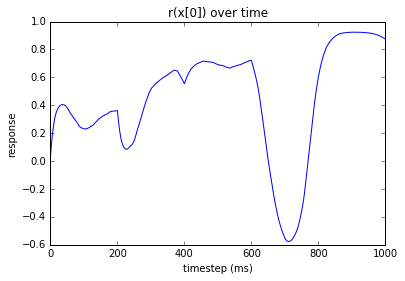


[[-0.08343045 -0.12491011  0.06589194 ..., -0.13777245  0.12165161
   0.11582892]
 [ 0.00280754  0.07018164  0.04308139 ...,  0.02469703 -0.14743194
  -0.08194902]
 [ 0.02223012  0.03910842  0.00947777 ...,  0.04328328  0.08520126
  -0.0386388 ]
 ..., 
 [-0.05461002  0.10585502 -0.05628894 ...,  0.07974142 -0.15984541
  -0.02995135]
 [ 0.15916944  0.04214129 -0.04824452 ..., -0.13190684  0.05663115
  -0.04545904]
 [ 0.02373353 -0.01901394  0.04518801 ...,  0.00932822  0.01127298
   0.05158576]]



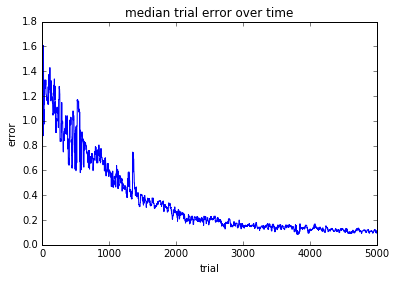

In [205]:
#%lprun -f run_trial_task_1 task1(50)
task1(5000)